# DC-TSS Example with EEG 

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
#from TS_DEC_Linear import *


from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cosine as cosine_distance
from typing import Optional, List
from scipy.io import arff

from scipy.signal import find_peaks, peak_prominences


import warnings
warnings.filterwarnings("ignore")

## Set Parameters

In [2]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 8000
lr=0.1
pre_lr = 1.5e-3
layers = [10,8,5]
strides = [3,3,2]
batch_size = 1500

# DC-TSS hyper-parameters
window_length = 160
overlap_percent = 0.5
n_clusters = 80
window_length2 = 250



## Read Dataset

In [3]:
#selected_songs = [2,140,30056,30058,85594,120308,120194,120112,120105]
time_series = np.loadtxt("./data/EEG.csv", delimiter=",")
labels = np.loadtxt("./data/EEG_labels.csv", delimiter=",")
ground_truth = np.where(labels[:-1] != labels[1:])[0]


## Subsequence TS

In [4]:
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)
    subsequences.append(np.roll(subsequence, -(window_length)//4))
    subsequences.append(np.roll(subsequence, (window_length)//4))
    subsequences.append(np.roll(subsequence, (window_length)//2))

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
batch_size = subsequences.shape[0]

## Set Data_loader for Neural Network?

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


data_loader = get_dataloader(data=subsequences,
                          shuffle=False,
                          batch_size=batch_size,
                          num_workers=1,
                          data_transforms=None)
torch.cuda.empty_cache()
input_shape = subsequences.shape
#torch.cuda.memory_summary(device=None, abbreviated=False)



cuda


## Create DC-TSS model

In [6]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.to(device)


DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(64, 64, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(64, 64, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(64, 64, kernel_size=(5,), stride=(2,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 64, kernel_size=(5,), stride=(2,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(64, 64, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(64, 64, kernel_size=(10,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      (0): Conv1d(64, 64, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(64, 64, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Con

## Phase 1: Initialize Latent Space Mapping with 1DCNN AE

In [7]:
pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1,lr=pre_lr)


epoch 1,loss = 1.00065708
epoch 2,loss = 1.00035942
epoch 3,loss = 0.99558765
epoch 4,loss = 0.97557592
epoch 5,loss = 0.91686249
epoch 6,loss = 0.87224680
epoch 7,loss = 0.83512002
epoch 8,loss = 0.80572766
epoch 9,loss = 0.77725852
epoch 10,loss = 0.73644537
epoch 11,loss = 0.69875437
epoch 12,loss = 0.69102138
epoch 13,loss = 0.67654908
epoch 14,loss = 0.64161134
epoch 15,loss = 0.63577855
epoch 16,loss = 0.64362413
epoch 17,loss = 0.62592024
epoch 18,loss = 0.61145270
epoch 19,loss = 0.59928864
epoch 20,loss = 0.59777141
epoch 21,loss = 0.59888518
epoch 22,loss = 0.58412522
epoch 23,loss = 0.57908964
epoch 24,loss = 0.57717568
epoch 25,loss = 0.57069117
epoch 26,loss = 0.56562573
epoch 27,loss = 0.55812472
epoch 28,loss = 0.55728966
epoch 29,loss = 0.55839235
epoch 30,loss = 0.55097216
epoch 31,loss = 0.54354274
epoch 32,loss = 0.54133356
epoch 33,loss = 0.53934926
epoch 34,loss = 0.53729117
epoch 35,loss = 0.53245020
epoch 36,loss = 0.52986342
epoch 37,loss = 0.52834207
epoch 38,l

epoch 298,loss = 0.26947552
epoch 299,loss = 0.26966709
epoch 300,loss = 0.26847351
epoch 301,loss = 0.26876771
epoch 302,loss = 0.26794645
epoch 303,loss = 0.26742667
epoch 304,loss = 0.26759574
epoch 305,loss = 0.26635131
epoch 306,loss = 0.26681840
epoch 307,loss = 0.26590541
epoch 308,loss = 0.26555151
epoch 309,loss = 0.26549190
epoch 310,loss = 0.26472753
epoch 311,loss = 0.26452571
epoch 312,loss = 0.26431075
epoch 313,loss = 0.26364923
epoch 314,loss = 0.26351997
epoch 315,loss = 0.26307806
epoch 316,loss = 0.26276788
epoch 317,loss = 0.26237109
epoch 318,loss = 0.26197106
epoch 319,loss = 0.26170596
epoch 320,loss = 0.26143536
epoch 321,loss = 0.26090318
epoch 322,loss = 0.26063415
epoch 323,loss = 0.26034179
epoch 324,loss = 0.25996587
epoch 325,loss = 0.25968325
epoch 326,loss = 0.25934058
epoch 327,loss = 0.25891230
epoch 328,loss = 0.25857580
epoch 329,loss = 0.25832108
epoch 330,loss = 0.25797424
epoch 331,loss = 0.25764635
epoch 332,loss = 0.25738198
epoch 333,loss = 0.2

epoch 591,loss = 0.20733821
epoch 592,loss = 0.20023754
epoch 593,loss = 0.20508072
epoch 594,loss = 0.20069599
epoch 595,loss = 0.20150924
epoch 596,loss = 0.20186290
epoch 597,loss = 0.19919187
epoch 598,loss = 0.20151904
epoch 599,loss = 0.19855528
epoch 600,loss = 0.19953701
epoch 601,loss = 0.19889854
epoch 602,loss = 0.19790868
epoch 603,loss = 0.19864443
epoch 604,loss = 0.19695927
epoch 605,loss = 0.19791478
epoch 606,loss = 0.19669056
epoch 607,loss = 0.19701412
epoch 608,loss = 0.19641230
epoch 609,loss = 0.19625723
epoch 610,loss = 0.19611408
epoch 611,loss = 0.19572683
epoch 612,loss = 0.19568264
epoch 613,loss = 0.19528131
epoch 614,loss = 0.19526246
epoch 615,loss = 0.19498333
epoch 616,loss = 0.19485810
epoch 617,loss = 0.19463235
epoch 618,loss = 0.19448180
epoch 619,loss = 0.19434267
epoch 620,loss = 0.19412977
epoch 621,loss = 0.19404797
epoch 622,loss = 0.19379404
epoch 623,loss = 0.19379012
epoch 624,loss = 0.19349721
epoch 625,loss = 0.19351467
epoch 626,loss = 0.1

epoch 884,loss = 0.18022902
epoch 885,loss = 0.17971396
epoch 886,loss = 0.17965597
epoch 887,loss = 0.17949881
epoch 888,loss = 0.17920303
epoch 889,loss = 0.17924573
epoch 890,loss = 0.17878236
epoch 891,loss = 0.17896074
epoch 892,loss = 0.17849240
epoch 893,loss = 0.17872436
epoch 894,loss = 0.17821263
epoch 895,loss = 0.17849170
epoch 896,loss = 0.17809145
epoch 897,loss = 0.17805883
epoch 898,loss = 0.17807481
epoch 899,loss = 0.17779706
epoch 900,loss = 0.17789468
epoch 901,loss = 0.17764223
epoch 902,loss = 0.17761581
epoch 903,loss = 0.17763023
epoch 904,loss = 0.17735796
epoch 905,loss = 0.17747432
epoch 906,loss = 0.17727362
epoch 907,loss = 0.17722313
epoch 908,loss = 0.17725331
epoch 909,loss = 0.17706153
epoch 910,loss = 0.17707478
epoch 911,loss = 0.17701924
epoch 912,loss = 0.17687795
epoch 913,loss = 0.17688200
epoch 914,loss = 0.17684625
epoch 915,loss = 0.17671919
epoch 916,loss = 0.17673178
epoch 917,loss = 0.17668411
epoch 918,loss = 0.17659180
epoch 919,loss = 0.1

epoch 1171,loss = 0.16695713
epoch 1172,loss = 0.16657233
epoch 1173,loss = 0.16655114
epoch 1174,loss = 0.16662580
epoch 1175,loss = 0.16608231
epoch 1176,loss = 0.16614357
epoch 1177,loss = 0.16628060
epoch 1178,loss = 0.16586956
epoch 1179,loss = 0.16584538
epoch 1180,loss = 0.16591863
epoch 1181,loss = 0.16565003
epoch 1182,loss = 0.16565371
epoch 1183,loss = 0.16570345
epoch 1184,loss = 0.16549785
epoch 1185,loss = 0.16535366
epoch 1186,loss = 0.16540653
epoch 1187,loss = 0.16532464
epoch 1188,loss = 0.16525304
epoch 1189,loss = 0.16521798
epoch 1190,loss = 0.16519937
epoch 1191,loss = 0.16510026
epoch 1192,loss = 0.16499811
epoch 1193,loss = 0.16496933
epoch 1194,loss = 0.16494255
epoch 1195,loss = 0.16486907
epoch 1196,loss = 0.16477463
epoch 1197,loss = 0.16476603
epoch 1198,loss = 0.16478601
epoch 1199,loss = 0.16479363
epoch 1200,loss = 0.16484940


In [8]:
torch.save(deep_cluster_model.state_dict(), './EEG_pretrain.pth')

In [9]:
deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
deep_cluster_model.load_state_dict(torch.load('./EEG_pretrain.pth'))
deep_cluster_model.to(device)

DEC(
  (AE): Autoencoder(
    (encoder): Sequential(
      (0): Conv1d(64, 64, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(64, 64, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Conv1d(64, 64, kernel_size=(5,), stride=(2,))
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 64, kernel_size=(5,), stride=(2,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): ConvTranspose1d(64, 64, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): ConvTranspose1d(64, 64, kernel_size=(10,), stride=(3,))
      (5): LeakyReLU(negative_slope=0.1)
      (6): Upsample(size=160, mode=nearest)
    )
  )
  (clustlayer): clustering()
  (model): Sequential(
    (0): Sequential(
      (0): Conv1d(64, 64, kernel_size=(10,), stride=(3,))
      (1): LeakyReLU(negative_slope=0.1)
      (2): Conv1d(64, 64, kernel_size=(8,), stride=(3,))
      (3): LeakyReLU(negative_slope=0.1)
      (4): Con

## Phase 2: Refine Latent Space and Find Clusters

In [10]:
# Refine on nonagumented subsequences (no np.roll())
start = 0
subsequences = []
subsequence_labels = []

while start+window_length < len(time_series[0]):
    subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
    subsequence = time_series[:,start:start+window_length]
    start = start+window_length - int(overlap_percent*window_length)
    subsequences.append(subsequence)
    

subsequences = np.asarray(subsequences)
subsequence_labels = np.asarray(subsequence_labels)
batch_size = subsequences.shape[0]
input_shape = subsequences.shape

data_loader = get_dataloader(data=subsequences,
                              shuffle=False,
                              batch_size=batch_size,
                              num_workers=1,
                              data_transforms=None)

# refine mapping
cluster_assignments = refine_clusters(n_clusters, data_loader, deep_cluster_model, device, epochs2, batch_size, lr, 0.0, 1)


Initializing cluster centers with k-means. number of clusters 80
torch.Size([3242, 64, 160])
1.0
Epoch 200:   loss= 0.1681  cluster difference= 1.0
Epoch 400:   loss= 0.18828  cluster difference= 0.34608266502159163
Epoch 600:   loss= 0.20846  cluster difference= 0.35101789019123997
Epoch 800:   loss= 0.22513  cluster difference= 0.23534855027760643
Epoch 1000:   loss= 0.23856  cluster difference= 0.1810610734114744
Epoch 1200:   loss= 0.24929  cluster difference= 0.11967921036397286
Epoch 1400:   loss= 0.25795  cluster difference= 0.11165946946329426
Epoch 1600:   loss= 0.26506  cluster difference= 0.08266502159161011
Epoch 1800:   loss= 0.27103  cluster difference= 0.10363972856261566
Epoch 2000:   loss= 0.27615  cluster difference= 0.0798889574336829
Epoch 2200:   loss= 0.28058  cluster difference= 0.07618753855644664
Epoch 2400:   loss= 0.28446  cluster difference= 0.05582973473164713
Epoch 2600:   loss= 0.28789  cluster difference= 0.0647748303516348
Epoch 2800:   loss= 0.29096  c

In [11]:
torch.save(deep_cluster_model.state_dict(), './EEG_refined.pth')

## Visualize Latent Space with t-SNE

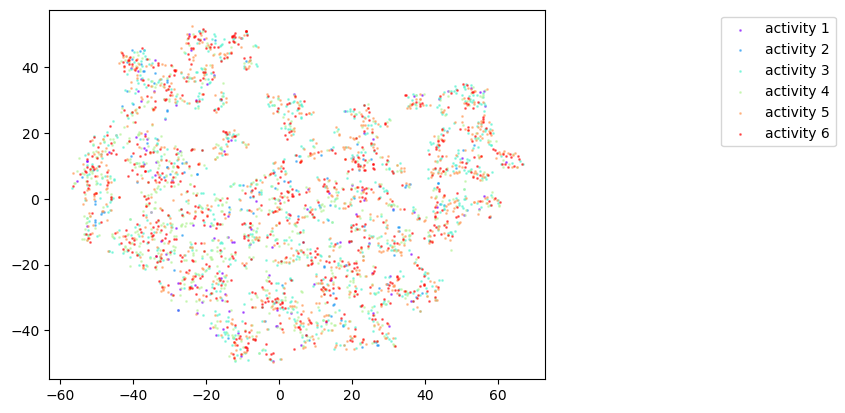

In [15]:
plt.style.use('default')
clustering_output = []
for ts in data_loader:
    recon = deep_cluster_model.AE.encode((ts.float().to(device)))
    clustering_output.append( recon.cpu().detach().numpy() ) 
    

clustering_output = [item for sublist in clustering_output for item in sublist]
?
clustering_output = np.asarray(clustering_output)
clustering_output_f = []
for i,co in enumerate(clustering_output):
    clustering_output[i].flatten()
    clustering_output_f.append(clustering_output[i].flatten())
clustering_output_f = np.asarray(clustering_output_f)

activities = []
activities.append(labels[0])
for l in labels:
    if l != activities[-1]:
        activities.append(int(l))


activity_names = ['activity 1',
                 'activity 2',
                 'activity 3',
                 'activity 4',
                 'activity 5',
                 'activity 6']

X_embedded = TSNE(n_components=2).fit_transform(clustering_output_f)

cmap = plt.get_cmap('rainbow')

l = np.unique(labels)
slicedCM = cmap(np.linspace(0, 1, len(l))) 



for m,la in enumerate(l): 
    ind = np.where(subsequence_labels==la)
    plt.scatter(X_embedded[ind,0],X_embedded[ind,1],color=slicedCM[m], label=activity_names[int(la)], alpha=0.5, s=1)

plt.legend(loc=1, bbox_to_anchor=(1.1, 0., 0.5, 1.0))

## Remove Duplicate Cluster Labels and Set Labels in Sequential Order

In [16]:
while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
    for assignment in range(np.max(cluster_assignments)+1):
        if assignment not in cluster_assignments:
            indx = np.where(cluster_assignments > assignment)
            cluster_assignments[indx] = cluster_assignments[indx]-1
    l = np.unique(cluster_assignments)

## Phase 3: Sldiing Window on Cluster Labels

In [17]:
window_length2 = window_length2
similarities = get_label_score(cluster_assignments, window_length2)


## Normalize and Smooth Sliding Window Distance

In [18]:
data = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
data = smooth(np.blackman(50), data)

In [19]:
peaks, peak_data = find_peaks(data, height=0.4,distance=window_length2//2,prominence=0.1)
real_peaks = peaks+window_length2//2
predictions = get_changepoints(real_peaks, window_length, overlap_percent)


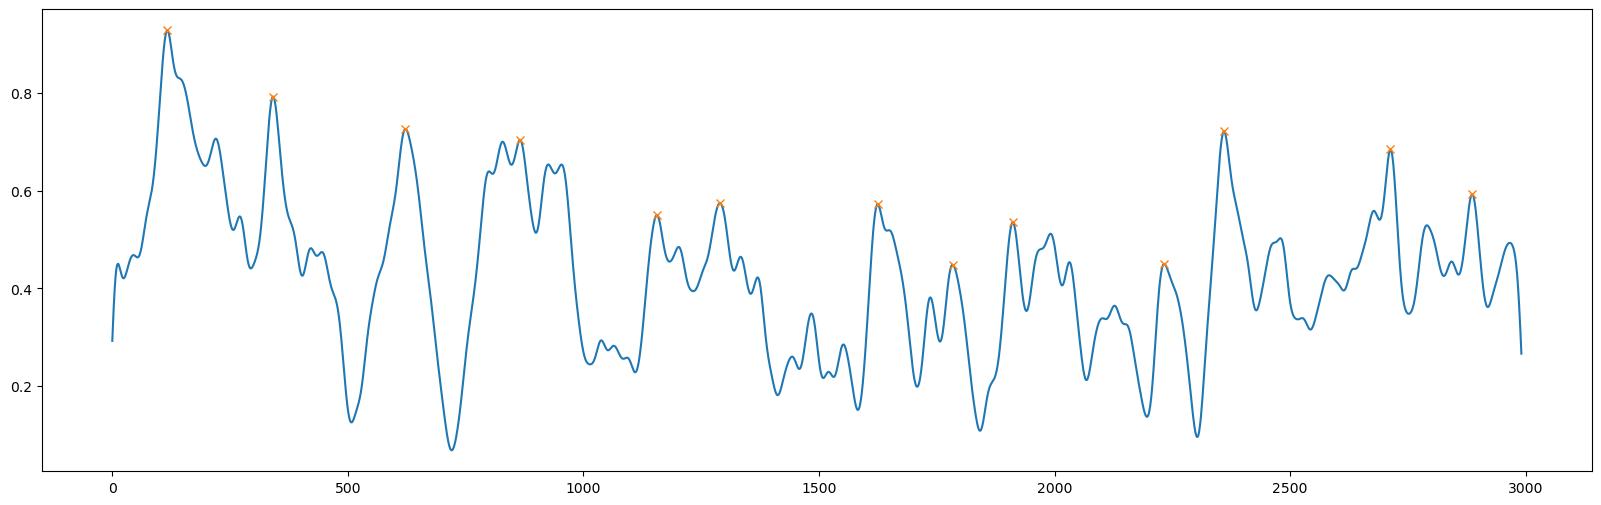

Space: Encoded Hidden Space
Clusters = 80


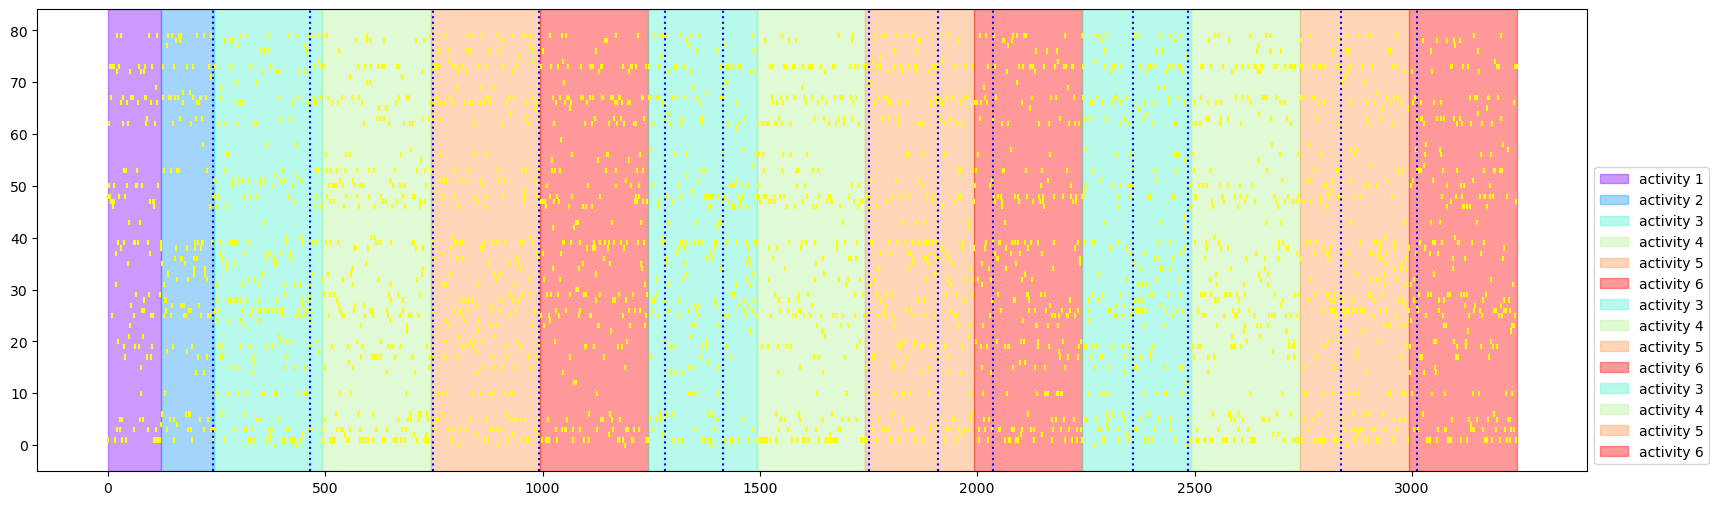

covering score: 0.7170906882938511
margin: 4200
f_measure score: (0.7142857142857143, 0.7142857142857143, 0.7142857142857143)


In [20]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')
cmap = plt.get_cmap('rainbow')

l = np.unique(labels)


slicedCM = cmap(np.linspace(0, 1, len(activity_names))) 


plt.plot(data)
plt.plot(peaks, data[peaks], "x")
plt.show()

positions = np.arange(len(cluster_assignments))[:,np.newaxis]

plt.eventplot(positions, lineoffsets=cluster_assignments, color = [(1.0,1.0,0.0)])

for vline in real_peaks:
    plt.axvline(x = vline, color = 'b', linestyle=':', mfc='b')

start = 0
subsequence_ground_truth = np.where(subsequence_labels[:-1] != subsequence_labels[1:])[0]
print("Space: Encoded Hidden Space\nClusters = {}".format(n_clusters))
for i, activity in enumerate(activities):
    if i == len(activities):
        continue
    if i == len(activities)-1:
        end = len(subsequence_labels)
    else:
        end = subsequence_ground_truth[i]

    plt.axvspan(start, end, alpha=0.4, color=slicedCM[int(activity)], label=activity_names[int(activity)])
    plt.legend(loc=3, bbox_to_anchor=(1, 0, 0, 1.0))
    start = end
plt.show()

print('covering score:',covering(ground_truth, predictions, len(labels)))
margin = 4200
print('margin:',margin)
print('f_measure score:',f_measure(ground_truth, predictions, margin=margin, alpha=0.5, return_PR=True))